In [66]:
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal

from importlib import reload

reload(fp)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import easygems.healpix as egh

import intake

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [96]:
import orcestra.sat
orcestra.sat.SattrackLoader("EARTHCARE", "2024-07-22").get_track_for_day("2024-08-11")

<xarray.Dataset>
Dimensions:  (time: 18)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-11T04:19:49 ... 2024-08-11T15:53:11
Data variables:
    lat      (time) float64 2.0 3.295 22.0 20.71 ... 6.478 5.183 3.889 2.594
    lon      (time) float64 -34.69 -34.94 -23.72 -23.99 ... -27.0 -27.24 -27.48
    heading  (time) float64 10.55 10.55 169.2 169.2 ... 169.4 169.4 169.4 169.4

In [67]:
def calc_zonal_mean(field, lon_min, lon_max, lat_min, lat_max): 
    import easygems.healpix as egh
    
    bbox = [lon_min, lon_max, lat_min, lat_max]
    
    in_bbox = egh.isel_extent(field, bbox) 

    field_bbox = field.sel(
        cell=in_bbox,
    )
    
    field_lat = field_bbox.groupby(
        field_bbox.lat
    ).mean(
    )
    return field_lat

def find_edges(cwv, cwv_thresh, cwv_min = 0, lat_cwv_max = 9.0):
    
    import scipy.signal
    
    """
    Determine latitude of peak in CWV that is closest to the latitude of peak CWV in the average CWV profile (lat_cwv_max).
    Assess where the moist tropics end by dropping all latitudes where CWV drops below cwv_min.
    Within the remaining moist band, assess the northernmost and southernmost latitude at which CWV is equal to cwv_thresh.
    
    If CWV is below cwv_thresh everywhere, return NAN values. 
    """

    if cwv.max().values <= cwv_thresh:
        lat_north, lat_south = np.nan, np.nan

    else:

        peaks_i, peaks_props = scipy.signal.find_peaks(cwv, height=cwv_thresh, prominence=2)
        
        if len(peaks_i) == 0:
            lat_north, lat_south = np.nan, np.nan

        else:
            dist_peaks = np.abs(lat_cwv_max - cwv.lat[peaks_i])
            cwv_lat_max = dist_peaks.lat[np.argmin(dist_peaks.values)]

            cwv_north = cwv.where((cwv.lat >= cwv_lat_max) & (cwv > cwv_min), drop = True)
            cwv_south = cwv.where((cwv.lat <= cwv_lat_max) & (cwv > cwv_min), drop = True)

            lat_north = float(cwv_north.lat.where(cwv_north<=cwv_thresh).min().values)
            lat_south = float(cwv_south.lat.where(cwv_south>=cwv_thresh).min().values)
            

    return lat_south, lat_north

def find_ec_lon(lat_sel, ec_lons, ec_lats):
    return ec_lons[np.argmin(np.abs(ec_lats-lat_sel))]

In [98]:
date_time = datetime(2024, 8, 1, 0, 0, 0)
date_time_str = date_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 11, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"
flight_index

'HALO-20240811a'

In [99]:
import pandas as pd
pd.Timestamp(flight_time).week

32

In [100]:
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [101]:
ds = cat.HIFS(refdate=date_time_str, reftime=date_time.hour).to_dask().pipe(egh.attach_coords)

ValueError: reftime=0 is not one of the allowed values: 00,12

In [71]:
ec = orcestra.sat.earthcare_track_loader()
track_all_day = ec.get_track_for_day(flight_time)
track = track_all_day.where(track_all_day.time.dt.hour.isin([15,16]), drop = True)
track = track.where((track.lat >= lat_min-1) & (track.lat <= lat_max+1), drop = True)
track = track.where((track.lon >= -50) & (track.lon <= 0), drop = True)

ec_lons, ec_lats = track.lon.values, track.lat.values

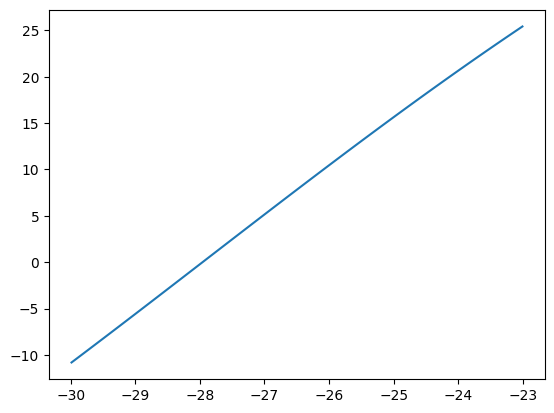

In [72]:
plt.plot(ec_lons, ec_lats)

In [97]:
cwv_ec_lat = calc_zonal_mean(ds[["tcwv", "crs"]], track.lon.min(), track.lon.max(), lat_min, lat_max).sel(
    time=flight_time, method = "nearest").tcwv

lat_edge_south, lat_edge_north = find_edges(cwv_ec_lat.compute(), 48.0)
lat_edge_south, lat_edge_north

(4.780191847199163, 15.094787099543197)

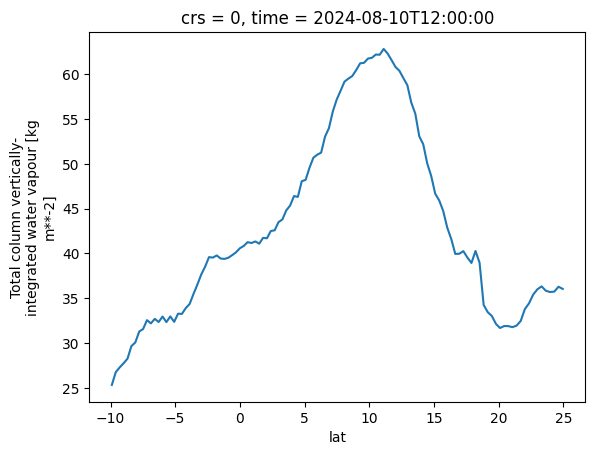

In [74]:
cwv_ec_lat.plot()

In [75]:
radius = 100e3
band = "east"

airport = sal if band == "east" else bco

lat_north = np.nanmax([airport.lat, lat_edge_north+2])
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")

In [76]:
edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")

center = edge_north.towards(edge_south).assign_label("center")

south = LatLon(edge_south.lat-2, find_ec_lon(edge_south.lat-1, ec_lons, ec_lats), "south")

returnPoint = north if band == "east" else LatLon(bco.lat, -53.0, "")


leg_south = [
     airport,
     north,
     south
]

leg_circles = [
     IntoCircle(edge_north, radius, 360),
     IntoCircle(center, radius, 360),
     IntoCircle(edge_south, radius, 360),
     north
]
    
leg_home = [
     returnPoint,
     airport
]

waypoints = leg_south + leg_circles + leg_home #

path = fp.expand_path(waypoints, dx=10e3)

#print(f"duration: {halo_flight_duration(path)}")

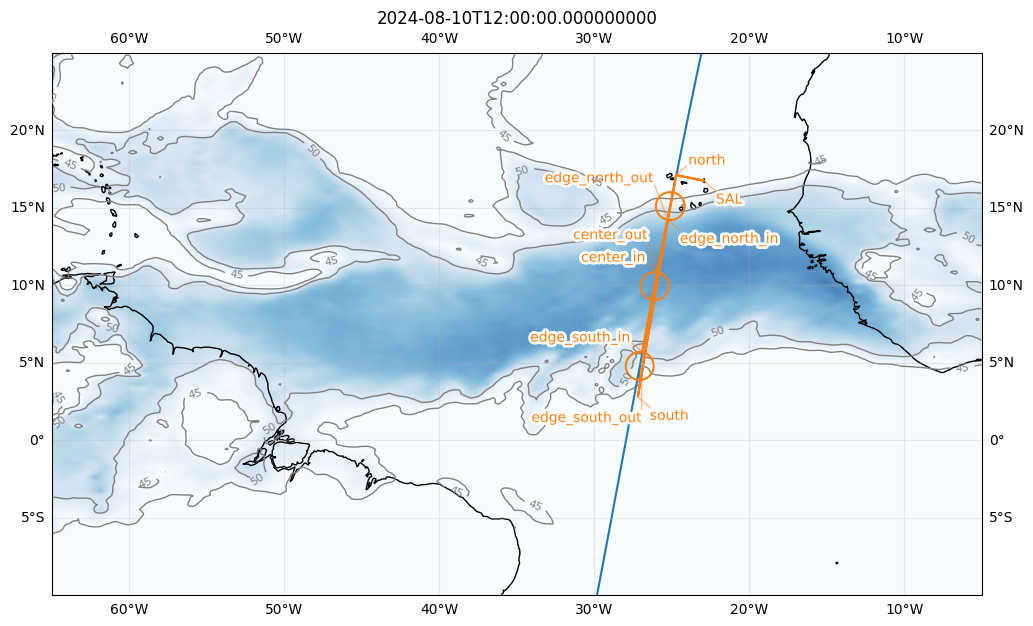

In [77]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time)
plt.title(cwv_flight_time.time.values)

plt.plot(track.lon, track.lat)
fp.plot_path(path, ax, color="C1")

In [78]:
lats, lons, labels = [], [], []

for point in waypoints:
    
    if isinstance(point, IntoCircle):
        point = point.center
        
    lats.append(point.lat)
    lons.append(point.lon)
    labels.append(point.label)
    
lats

[16.73448797020352,
 17.094787099543197,
 2.7801918471991627,
 15.094787099543197,
 9.939729192430752,
 4.780191847199163,
 17.094787099543197,
 17.094787099543197,
 16.73448797020352]

In [79]:
test = IntoCircle(center=LatLon(lat=8.600792496708406, lon=-26.357679545881698, label='center'), radius=100000.0, angle=360, enter=None)
test.center.lat

8.600792496708406

In [80]:
isinstance(test, IntoCircle)

True

In [81]:
import csv

# The name of your output file
flight_name = f"flight_data_{flight_index}.csv"

# Open a file in write mode
with open(flight_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')

    # Write the header
    writer.writerow([flight_index])
    writer.writerow(["Index", "Location", "Lat (+-90)", "Lon (+-180)", "Comments"])

    # Write the data rows
    for index, (lat, lon, label) in enumerate(zip(lats, lons, labels)):
        writer.writerow([index, "", lat, lon, label])

print(f"CSV file '{flight_name}' created successfully.")

CSV file 'flight_data_HALO-20240811a.csv' created successfully.


In [82]:

# Example lists
lats = [16.736, 17.404, -0.210, 0.881]
lons = [-22.947, -24.660, -27.865, -27.620]
labels = ["", "", "", "Hexagon 1"]

# The name of your output file
flight_name = "flight_data.csv"

# Open a file in write mode
with open(flight_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')

    # Write the header
    writer.writerow(["flight_name"])
    writer.writerow(["Index", "Location", "Lat (+-90)", "Lon (+-180)", "Comments"])

    # Write the data rows
    for index, (lat, lon, label) in enumerate(zip(lats, lons, labels)):
        writer.writerow([str(index), "", f"{lat}", f"{lon}", f"{label}"])

print(f"CSV file '{flight_name}' created successfully.")

CSV file 'flight_data.csv' created successfully.


In [83]:
# Example lists
lats = [16.736, 17.404, -0.210, 0.881]
lons = [-22.947, -24.660, -27.865, -27.620]
labels = ["Sal", "", "", "Hexagon 1"]
flight_levels = [0.000, 410.000, 420.000, 230.000]
pressures = [1013.250, 178.738, 170.350, 409.999]
leg_dists = [0.0, 196.8, 1979.7, 123.7]
cum_dists = [0.0, 196.8, 2176.4, 2300.1]

# The name of your output file
output_file_name = "flight_track.txt"

# Open a file in write mode
with open(output_file_name, mode='w') as file:
    # Write the header comment
    file.write("# Do not modify if you plan to import this file again!\n")
    
    # Write the track name line
    file.write("Track name: dummy_flight\n")
    
    # Write the column headers
    file.write("Index  Location  Lat (+-90)  Lon (+-180)  Flightlevel  Pressure (hPa)  Leg dist. (km)  Cum. dist. (km)  Comments\n")
    
    # Write the data rows
    for index, (lat, lon, label, flight_level, pressure, leg_dist, cum_dist) in enumerate(zip(lats, lons, labels, flight_levels, pressures, leg_dists, cum_dists)):
        # Format each row according to the specified column widths
        row = (
            f"{index:5d} "                     # Index (right-aligned in 5 characters)
            f"{'':<10} "                      # Location (empty, left-aligned in 10 characters)
            f"{lat:10.3f} "                   # Lat (+-90) (right-aligned in 10 characters with 3 decimal places)
            f"{lon:10.3f} "                   # Lon (+-180) (right-aligned in 10 characters with 3 decimal places)
            f"{flight_level:12.3f} "         # Flightlevel (right-aligned in 12 characters with 3 decimal places)
            f"{pressure:12.3f} "             # Pressure (hPa) (right-aligned in 12 characters with 3 decimal places)
            f"{leg_dist:15.1f} "             # Leg dist. (km) (right-aligned in 15 characters with 1 decimal place)
            f"{cum_dist:15.1f} "             # Cum. dist. (km) (right-aligned in 15 characters with 1 decimal place)
            f"{label}\n"                     # Comments (left-aligned with no specific width)
        )
        file.write(row)

print(f"Text file '{output_file_name}' created successfully.")

Text file 'flight_track.txt' created successfully.
